In [47]:
import networkx as nx
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import collections

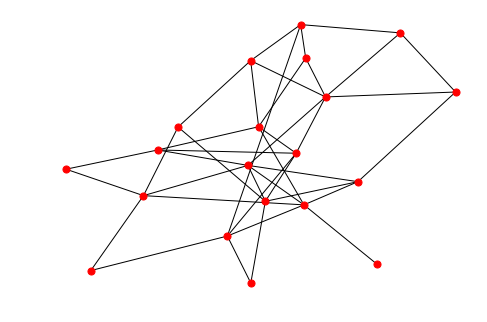

In [32]:
#Generate random (Erdos-Renyi) network and assign cooperation values to each node
def newRandom(N,p):

    ERnetwork = nx.erdos_renyi_graph(N,p)
    
    #"dictionary of dictionaries" structure
    attr= dict() #dictionary of nodes
    for node in ERnetwork.nodes():
        nodeDict=dict() #dictionary of various attributes
        nodeDict["coop"]=float('%.0f' %np.random.rand())
        attr[node]=nodeDict 

    nx.set_node_attributes(ERnetwork, attr)

    attrEdge = dict()
    for edge in ERnetwork.edges():
        edgeDict=dict()
        edgeDict['weight']=float('%.3f' %np.random.rand()) #for randomly weighted networks, if we want binary weighting (0/1), set to .0f
        attrEdge[edge]=edgeDict
        
    nx.set_edge_attributes(ERnetwork, attrEdge)
    
    return ERnetwork

graph=newRandom(20,0.2)
nx.draw(graph, node_size=50)
plt.show()

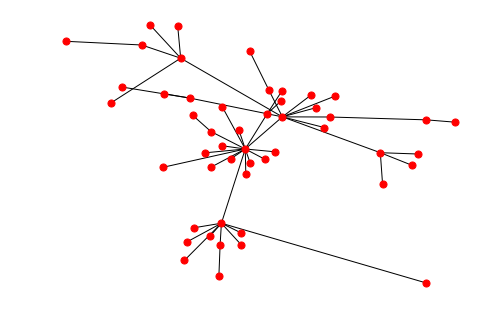

In [33]:
#Generate scale-free (Barabasi-Albert) network
def newScaleFree(N,m):
    BAnetwork = nx.barabasi_albert_graph(N,m)
    attr=dict()
    for node in BAnetwork.nodes():
        nodeDict=dict()
        nodeDict["coop"]=float('%.0f' %np.random.rand())
        attr[node]=nodeDict
    
    nx.set_node_attributes(BAnetwork, attr)
    
    attrEdge=dict()
    for edge in BAnetwork.edges():
        edgeDict=dict()
        edgeDict["weight"]=float('%.3f' %np.random.rand()) #random sulyozas
        attrEdge[edge]=edgeDict
        
    nx.set_edge_attributes(BAnetwork, attrEdge)
    
    return BAnetwork

graph=newScaleFree(50,1)
nx.draw(graph, node_size=50)

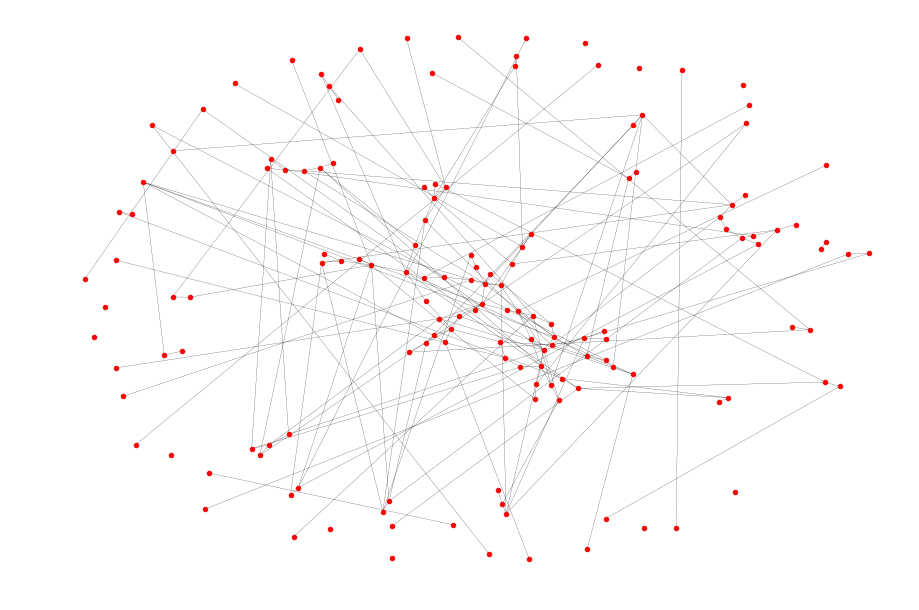

In [34]:
#Generate TOIVONEN MODEL SOCIAL NETWORK: https://arxiv.org/pdf/physics/0601114.pdf. We use a simplified version in which the probability of the number of selected contacts is normally distributed.

def newSocialNetwork(m0,mr,ms,Nmax,p,initialcoop):
    
    G = nx.erdos_renyi_graph(m0,p)
    N=m0
    #start with random network
    for i in range (Nmax-m0): #grow to desired size
        G.add_node(m0+i) 
        for node in G.nodes():
            x=np.random.rand()
            if x<=(mr/N): #probability of selecting each individual node as an initial contact
                if node != m0+i:
                    G.add_edge(node,m0+i)
                    for neighbor in G.neighbors(node):
                        y=np.random.rand()
                        if y<=(ms/N): #probability of selecting the neighbour of an initial contact as a secondary contact
                            G.add_edge(neighbor,m0+i)
        N=G.number_of_nodes()
    
    #ASSIGN STRATEGY TO EACH NODE (RANDOMLY, ONLY THE RATIO OF COOPERATION TO DEFECTION IS GIVEN)
    attr=dict()
    for node in G.nodes():
        nodeDict=dict()
        x=np.random.uniform(0,1)
        if x<=initialcoop:
            nodeDict["coop"]=1
        else:
            nodeDict["coop"]=0
        attr[node]=nodeDict
        
    nx.set_node_attributes(G, attr)
        
    attrEdge=dict()
    for edge in G.edges():
        edgeDict=dict()
        edgeDict["weight"]=float('%.0f' %np.random.rand()) #random sulyozas -> de ezt kesobb lehetne varialni...
        attrEdge[edge]=edgeDict
            
    nx.set_edge_attributes(G, attrEdge)
        
    return(G)

plt.figure(figsize=(12,8))
graph= newSocialNetwork(10,1.5,0.02,150,0.01,0.15)
nx.draw(graph, node_size=20, width=0.2)

In [35]:
def payNode(network,node,temptation=5): #Get results of "game" and assign payoff to a certain node (from games with all other nodes)
    #PAYOFF MATRIX:
    P=1
    R=3
    S=0
    payoffMatrix=[[R,S],[temptation,P]] #temptation parameter is variable but default value is 5
    
    self = int(network.nodes[node]["coop"]==0) #0, if "coop" is 1, 1, if "coop" is zero; boolean to int
    payoff=0
    
    for neighbor in network.neighbors(node):
        opponent= int(network.nodes[neighbor]["coop"]==0)
        payoff+=payoffMatrix[self][opponent] #payoff is entry of payoff matrix with indices given by the coop attribute of players
        
    network.nodes[node]["payoff"]=payoff
    
def updatePayoff(network,temptation): #Assign payoff for all nodes in network
    for node in network.nodes():
        payNode(network,node,temptation)

In [36]:
def draw(network):
    
    color=[]
    labels={} #ennek dictnek kell lennie
    for node in network.nodes():
        color.append(network.nodes[node]["coop"])
        labels[node]=str(node) + ": C=" + str(network.nodes[node]["coop"])

    edgeLabels = {}
    for edge in network.edges():
        edgeLabels[edge]=str(network.edges[edge]['weight'])

    plt.figure(figsize=(8,8))
    netLayout=nx.spring_layout(network,weight='weight')
    nx.draw(network,netLayout,node_color=color,cmap="RdYlGn",node_size=100)#minden kiv label
    nx.draw_networkx_labels(network,netLayout,labels,font_size=5)#a második egy ilyen positionös cucc
    nx.draw_networkx_edge_labels(network,netLayout,edgeLabels,font_size=2)

    #axis("equal")#szépkerek

In [148]:
def updateNode (network,node): #Best Takesover
    
    maxPayoff=network.nodes[node]["payoff"]
    maxPayNodes=[node]
    
    for neighbor in network.neighbors(node):
        if network.nodes[neighbor]["payoff"] == maxPayoff:
            maxPayNodes.append(neighbor)
        else:
            if network.nodes[neighbor]["payoff"]  > maxPayoff:
                maxPayoff=network.nodes[neighbor]["payoff"]
                maxPayNodes=[neighbor]
    network.nodes[node]["coop"]=network.nodes[random.choice(maxPayNodes)]["oldCoop"]
    
    
def updateStrategies(network,updatefraction=1):
    updatenumber=int(nx.number_of_nodes(network)*updatefraction)
    toupdate=np.random.choice(network.nodes(),updatenumber,replace=False)
    for node in network:
        network.nodes[node]["oldCoop"]=network.nodes[node]["coop"]
    
    for node in toupdate:
        updateNode(network,node)

In [38]:
def nextRound(G,temptation=5,updatefraction=1):
    #startTime= time.time()
    updatePayoff(G,temptation)
    updateStrategies(G,updatefraction)
    #draw(G)
    #print (time.time()-startTime)

In [39]:
def getGameCentrality(G):
    GC=0
    for node in G.nodes():
        GC+=G.nodes[node]["coop"]
        
    GC/=G.number_of_nodes()
    return GC

#average game centrality for entire network (this is the same as the proportion of cooperating nodes)

In [40]:
def getGCnode(node):
    GC=0
    if G.degree(node) != 0:
        N=G.neighbors(node) #type list
        for neighbor in N:
            GC+=G.nodes[neighbor]["coop"]
        GC/=G.degree(node)
        G.nodes[node]["gamecentrality"]=GC #creates new attribute
        return GC
    else:
        return "N/A" #game centrality can only be interpreted for a node with at least one neighbour.       

#game centrality for given node - some nodes will have a higher proportion of cooperating neighbours than others

In [41]:
def maxGC(G):
    maxGC=0
    for node in G.nodes():
        getGCnode(node)
        if getGCnode(node)>maxGC:
            maxGC=getGCnode(node)
    return maxGC
def minGC(G):
    minGC=0
    for node in G.nodes():
        getGCnode(node)
        if getGCnode(node)<minGC:
            minGC=getGCnode(node)
    return minGC

#calculate maximum and minimum game centralities across nodes in network

In [113]:
def getSpeed(GCarray):
    speedarray=np.zeros((2,GCarray.shape[1]))
    for i in range(speedarray.shape[1]-1):
        speedarray[0][i]=i
        speedarray[1][i]=GCarray[1][i+1]-GCarray[1][i]
    return speedarray

def getAcceleration(GCarray):
    accarray=np.zeros((2,GCarray.shape[1]))
    for i in range(accarray.shape[1]-2):
        x2=GCarray[1][i+2]-GCarray[1][i+1]
        x1=GCarray[1][i+1]-GCarray[1][i]
        accarray[0][i]=i
        accarray[1][i]=x1-x2
    return accarray

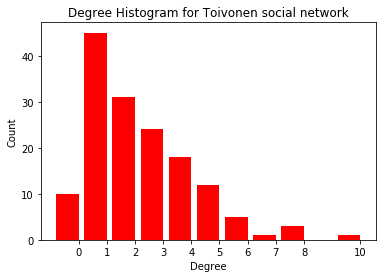

In [43]:
#PLOT DEGREE HISTOGRAM

degree_sequence = sorted([d for n, d in graph.degree()], reverse=False)  # degree sequence; (n,d) is tuple of node number and degree
#print("Degree sequence", degree_sequence)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='r')

plt.title("Degree Histogram for Toivonen social network")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)


plt.show()

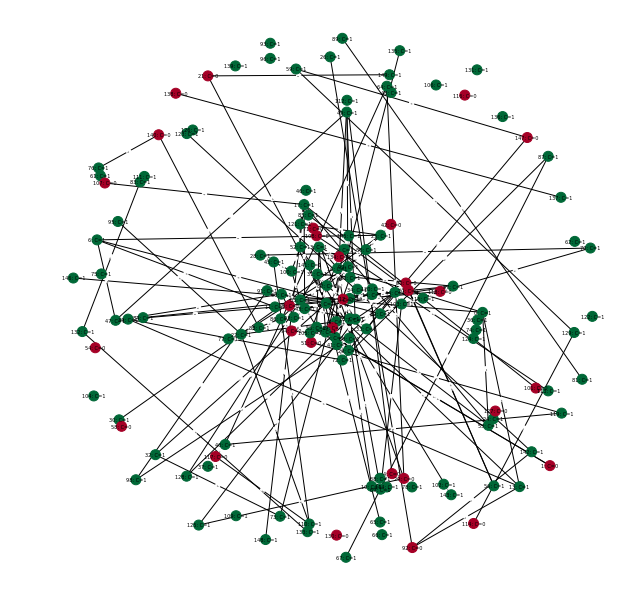

In [151]:
simulations=100
steps=25
gc=np.zeros(steps)

for s in range(simulations):
    graph= newSocialNetwork(10,1.5,0.02,150,0.01,0.4)
    time=np.arange(0,steps,1)
    
    speed=np.zeros(steps)
    accelaration=np.zeros(steps)

    for t in time:
        gc[t] += getGameCentrality(graph)
        nextRound(graph,5,0.02)
gc/=simulations

In [152]:
gcarray=np.array([np.arange(0,steps,1),gc])
speed=getSpeed(gcarray)
acceleration=getAcceleration(gcarray)

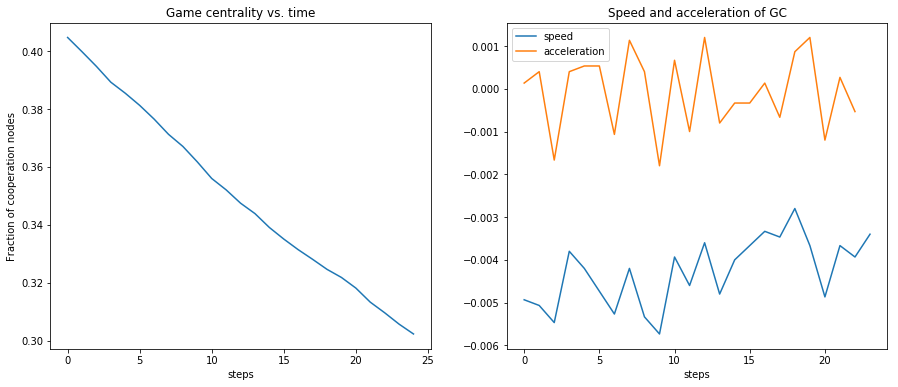

In [156]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Game centrality vs. time")
plt.xlabel("steps")
plt.ylabel("Fraction of cooperation nodes")
plt.plot(time,gc)
plt.subplot(1,2,2)
plt.title("Speed and acceleration of GC")
plt.xlabel("steps")
plt.plot(speed[0][:-1],speed[1][:-1],label="speed")
plt.plot(acceleration[0][:-2],acceleration[1][:-2],label="acceleration")
plt.legend()
plt.show()